# Iowa Liquor Store Expansion
*A (hypothetical) company is opening a new store in Iowa. Iowa is a big state. To narrow their search for the "perfect location", they're hired us to pick the top three counties for a new liquor store.*
![Liquor Bottles](http://www.thecarycompany.com/media/img/page/glass-liquor-bottles.png)

### Importing Data

In [1]:
# Import all Iowa liquor transactions from Jan 2015 to Mar 2016 from stores with a Class E liquor license

import numpy as np
import pandas as pd
from beakerx import *

df = pd.read_csv('~/blane07/GA/iowa_liquor_sales_proj_2.csv', infer_datetime_format=True, dayfirst=True);

/home/raven/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
print('Memory usage: ' + str(round(df.memory_usage().sum() / 1e6, 1)) + 'MB')

Memory usage: 520.2MB


In [3]:
df.shape

(2709552, 24)

In [6]:
df.head(10)

### Data Cleaning

In [7]:
# Any missing data?

for col in df:
    if df[col].isnull().sum() > 0:
        print(col, df[col].isnull().sum())

County Number 10913
County 10913
Category 779
Category Name 6109


In [8]:
# There's a small number of missing. They filter them out.

df.dropna(inplace=True)

In [9]:
# Verify no more missing data

df.isnull().sum().sum()

0

In [10]:
def remove_char(str):
    for s in '\'/!@#$%^&*();:?<>,.\"':
        str = str.replace(s, '')
    return(str)

In [11]:
# Data cleaning

df.loc[:, 'State Bottle Cost'] = df['State Bottle Cost'].apply(lambda x: float(x.replace('$', '')))    # obj --> float
df.loc[:, 'Sale (Dollars)'] = df['Sale (Dollars)'].apply(lambda x: float(x.strip('$')));    # Convert string sales to floats
df.loc[:, 'Profit'] = df['Sale (Dollars)'] - (df['Bottles Sold'] * df['State Bottle Cost'])    # Profit per transaction
df.drop(['Invoice/Item Number', 'Store Number', 'Vendor Number', 'Address', 'City', 'Zip Code', 
         'Store Location', 'County Number', 'Category', 'Category Name', 'Vendor Name',
         'Item Number', 'Item Description', 'Pack', 'Bottle Volume (ml)', 'State Bottle Cost', 
         'State Bottle Retail', 'Volume Sold (Gallons)'], axis='columns', inplace=True);
df = df.sort_values('Store Name').sort_values('County');
df.Date = df.Date.apply(lambda x: int(x.split('/')[2] + x.split('/')[0] + x.split('/')[1]));   # YYYYMMDD
df.loc[:, 'Price per Bottle'] = df['Sale (Dollars)'] / df['Bottles Sold']    # Price per bottle per transaction
df.loc[:, 'Month'] = df.Date.apply(lambda x: int(str(x)[4:6]))
df.loc[:, 'Year'] = df.Date.apply(lambda x: int(str(x)[0:4]))
df.loc[:, 'Store Name'] = df['Store Name'].apply(lambda x: x.replace("R 'n D's Liquor, Llc", "R n Ds Liquor, Llc"))    # Cleaning store names with weird characters
df.drop('Date', axis='columns', inplace=True)
df.loc[:, 'Store Name'] = df['Store Name'].apply(lambda x: remove_char(x))    # Removing bad characters from all store names

In [12]:
# Filting out all outliers that are more than three standard deviations from the mean | Reference: https://www.kdnuggets.com/2017/02/removing-outliers-standard-deviation-python.html
# How does this affect the data? Removing improperly entered data helps us. If the busines is in wholesale liquor distribution, then filtering outliers does not help us.

for col in ['Bottles Sold', 'Sale (Dollars)', 'Volume Sold (Liters)', 'Price per Bottle']:
    df = df[(df[col] < np.mean(df[col]) + 3 * np.std(df[col])) & (df[col] > np.mean(df[col]) - 3 * np.std(df[col]))]

### Exploratory Data Analysis

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
sns.set_color_codes("pastel")

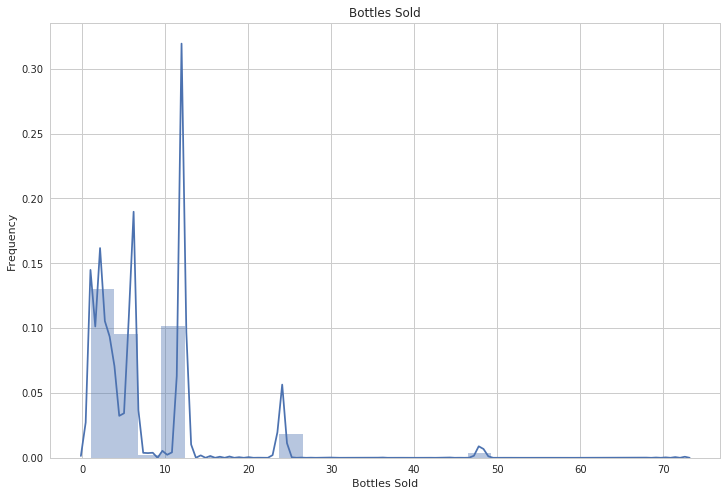

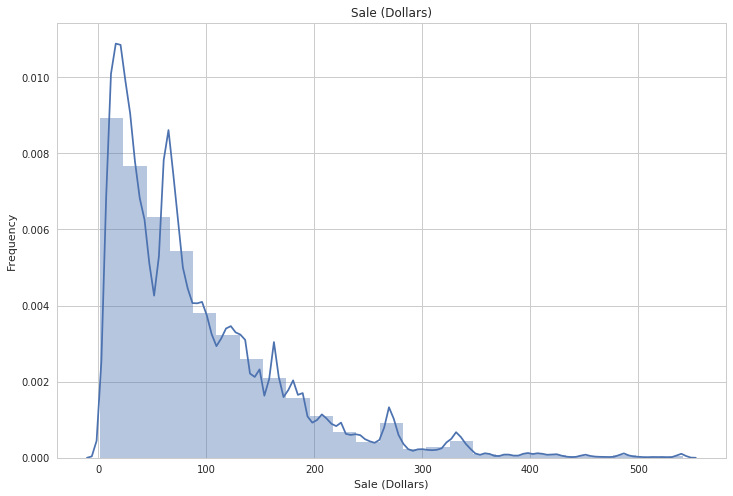

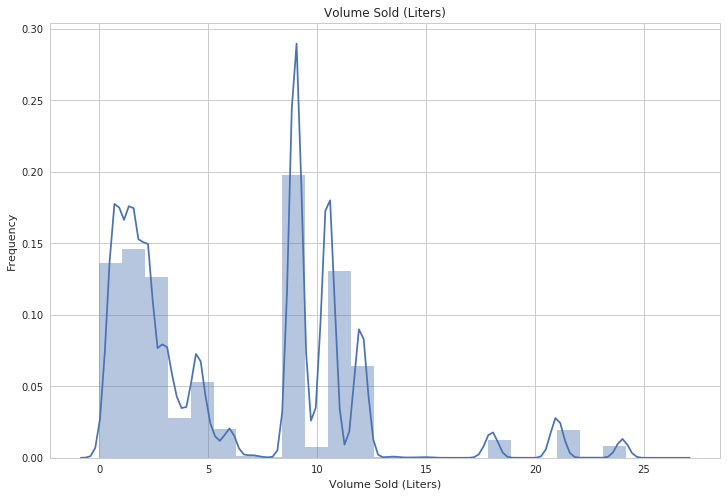

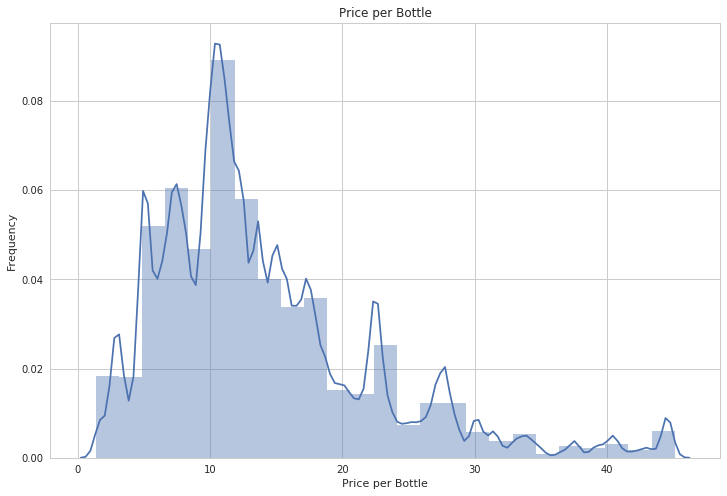

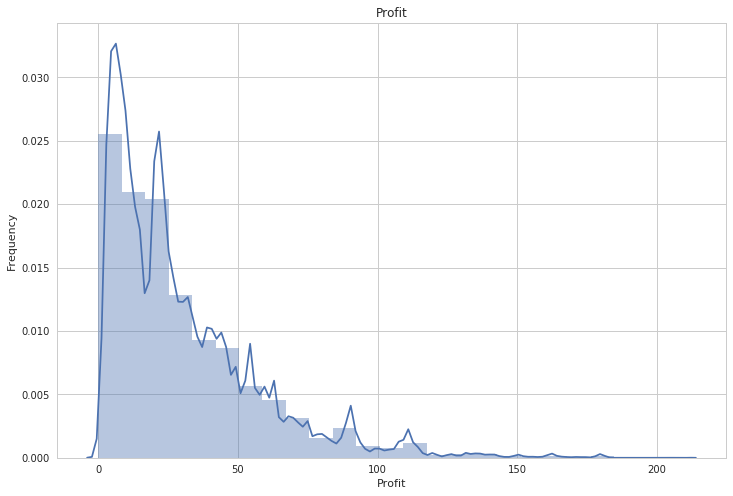

In [29]:
# Histograms

for col in ['Bottles Sold', 'Sale (Dollars)', 'Volume Sold (Liters)', 'Price per Bottle', 'Profit']:
    plt.subplots(figsize=(12, 8))
    sns.distplot(df[col], bins=25)
    plt.ylabel('Frequency')
    plt.title(col)
    plt.show()

*Sales and profits follow a similar Poisson distribution. Price per bottle follows a normal distibution.*

In [30]:
round(df.describe(), 2)

*Useful information about liquor transaction. Recommend using median values instead of mean because of amount of outliers*

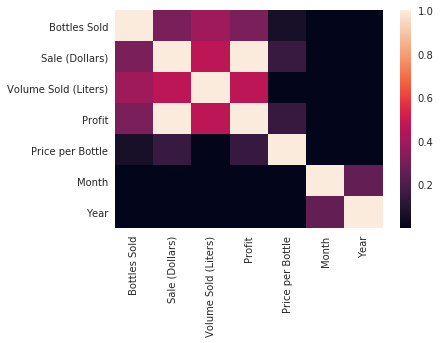

In [31]:
# Correlation matrix

sns.heatmap(df.corr()**2);    # Correlation is squared to force the scale from 0 to 1

*Profit is correlated with bottles sold, sales, volume sold, and slightly with price per bottle*

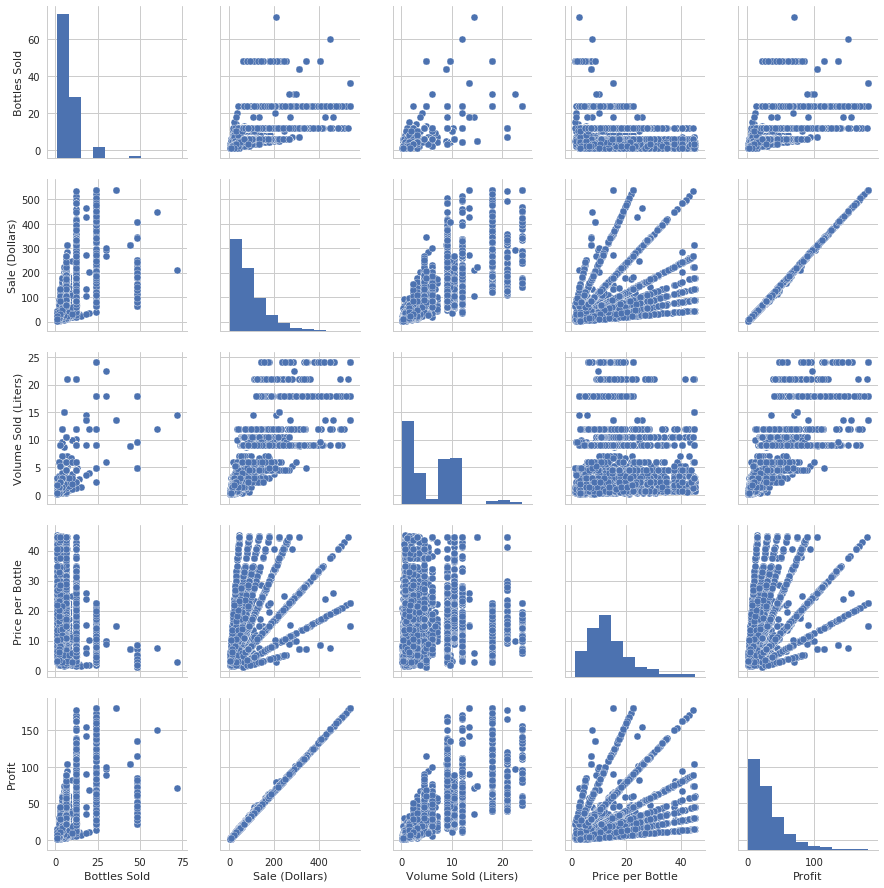

In [32]:
# Scatter plots and histograms (along the diagonal)

sns.pairplot(df[['Bottles Sold', 'Sale (Dollars)', 'Volume Sold (Liters)', 'Price per Bottle', 'Profit']].sample(10000))

*Sales and profits have a high degree of linearity. Other featured compared to profits have an increasing degree of variance as that feature increases in value.*

In [25]:
county_sales = df[['County', 'Profit']].groupby(['County']).agg([np.sum])
county_sales.columns = ['total profit']

###  DISCLAIMER: 'SALES' means 'PROFITS' in the following variable names

In [26]:
top_county_sales = county_sales['total profit'].sort_values(ascending=False)

In [27]:
top_county_sales.head(7)

County
Polk             1.466312e+07
Linn             6.559739e+06
Scott            5.007099e+06
Johnson          4.358501e+06
Black Hawk       4.338248e+06
Pottawattamie    2.787860e+06
Woodbury         2.780782e+06
Name: total profit, dtype: float64

*Focusd on the top seven counties by net profit*

In [33]:
# Set global plot parameters | https://stackoverflow.com/questions/12444716/how-do-i-set-the-figure-title-and-axes-labels-font-size-in-matplotlib

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),
          'axes.labelsize': 22,
          'axes.titlesize': 30,
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

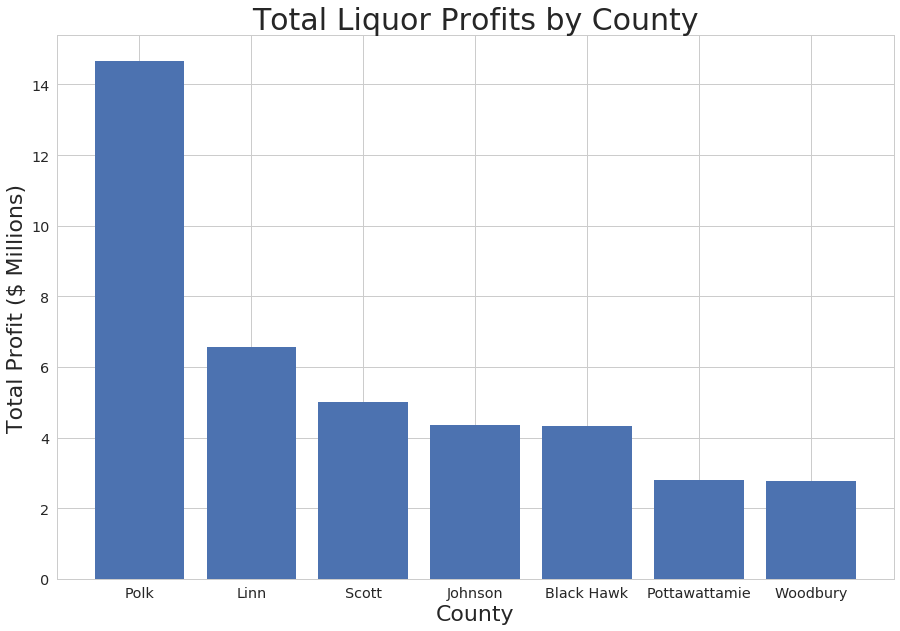

In [34]:
# https://matplotlib.org/examples/pylab_examples/custom_ticker1.html
from matplotlib.ticker import FuncFormatter
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1i' % (x*1e-6)

formatter = FuncFormatter(millions)

fig, ax = plt.subplots()
plt.bar(range(0,7), top_county_sales.head(7))
ax.yaxis.set_major_formatter(formatter)
plt.xticks(range(0,7), top_county_sales.head(7).index)
plt.title('Total Liquor Profits by County')
plt.xlabel('County')
plt.ylabel('Total Profit ($ Millions)')
plt.show()

In [37]:
top_county_stores = list(top_county_sales.index[0:7])
top_county_stores_population = [474045, 221661, 172474, 146547, 132904, 93582, 102779]    # https://www.iowa-demographics.com/counties_by_population

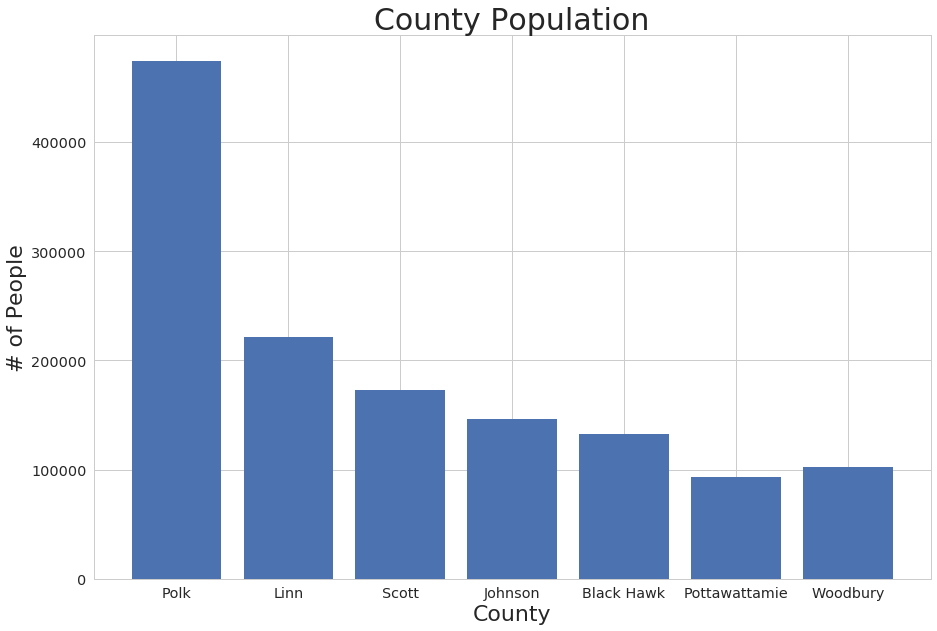

In [38]:
fig, ax = plt.subplots()
plt.bar(range(0,7), top_county_stores_population)
plt.xticks(range(0,7), top_county_sales.head(7).index)
plt.title('County Population')
plt.xlabel('County')
plt.ylim(ymin=80)
plt.ylabel('# of People')
plt.show()

*Appears similiar to new profit per county.*

In [39]:
sales_per_person = np.array(top_county_sales.head(7)) / np.array(top_county_stores_population)

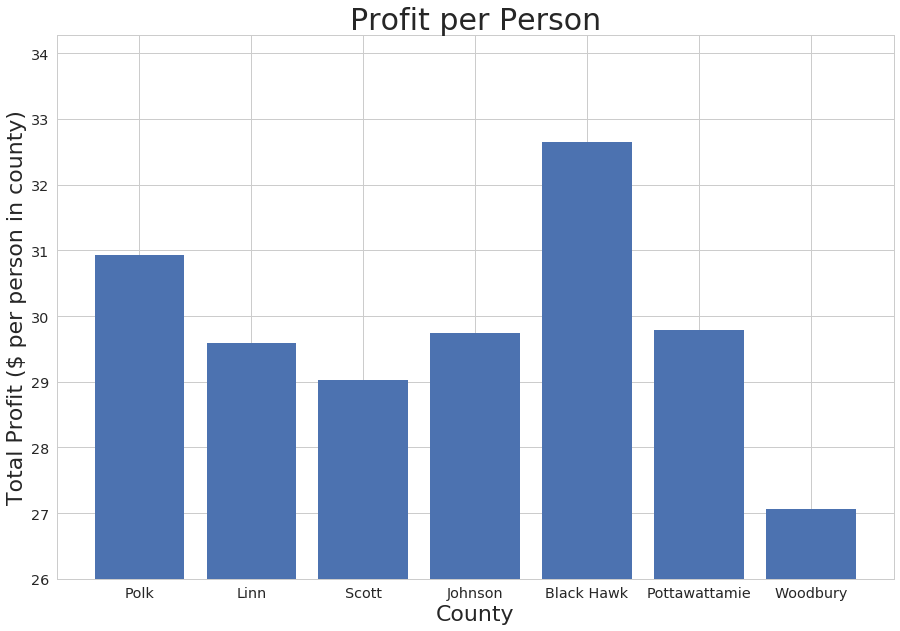

In [40]:
fig, ax = plt.subplots()
plt.bar(range(0,7), sales_per_person)
# ax.yaxis.set_major_formatter(formatter)
plt.xticks(range(0,7), top_county_sales.head(7).index)
plt.title('Profit per Person')
plt.xlabel('County')
plt.ylim(ymin=26)
plt.ylabel('Total Profit ($ per person in county)')
plt.show()

*The net profit and population per county looked similiar. But if you get down to the profit per capita, then it becomes apparent that there's a difference. This of this as the "how fertile is the soil" for a new liquor store.*

In [41]:
# https://stackoverflow.com/questions/15411158/pandas-countdistinct-equivalent

number_of_stores = df.groupby('County')['Store Name'].nunique()

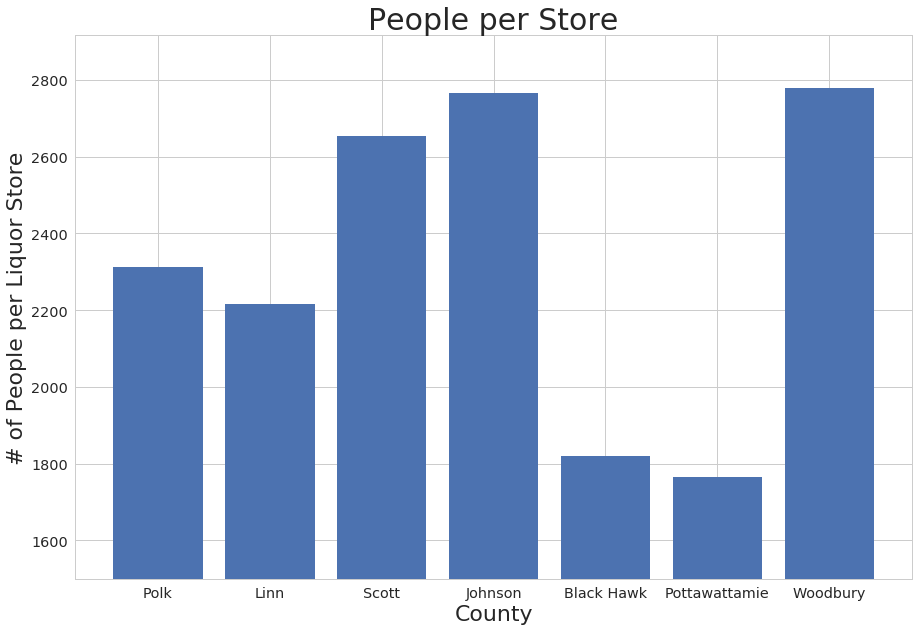

In [42]:
fig, ax = plt.subplots()
plt.bar(range(0,7), np.array(top_county_stores_population) / number_of_stores[top_county_stores])
# ax.yaxis.set_major_formatter(formatter)
plt.xticks(range(0,7), top_county_sales.head(7).index)
plt.title('People per Store')
plt.xlabel('County')
plt.ylim(ymin=1500)
plt.ylabel('# of People per Liquor Store')
plt.show()

*This plot shows the marketplace saturation of each county.*

In [43]:
# Filtering dataframe. Keeping the top counties by total sales

df = df[(df.County=='Polk') | (df.County=='Linn') | (df.County=='Scott') | (df.County=='Johnson') | (df.County=='Black Hawk') | (df.County=='Pottawattamie') | (df.County=='Woodbury')]

In [44]:
df1 = df[['County', 'Bottles Sold', 'Profit', 'Price per Bottle']]
df1.loc[:, 'Bottles Sold'] = df1['Bottles Sold'].apply(lambda x: float(x))
df1 = pd.get_dummies(df1, drop_first=True);    # Use Blawk Hawk county as reference

/home/raven/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### Creating Linear Regression for Statistical Inference

*Does location affect profit? Let's create a linear model to explore the relationship between profits and other features.*

In [47]:
# Independent variable
X = df1[['Bottles Sold', 'Price per Bottle', 'County_Johnson', 'County_Linn', 'County_Polk', 'County_Pottawattamie', 'County_Scott', 'County_Woodbury']]

# Dependent variable
y = df1['Profit']

In [48]:
# Splits data into training and test data sets

from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [50]:
# Creates linear model

import statsmodels.api as sm
X_train_c = sm.add_constant(X_train);   # Adds a y-intercept column to improve linear model's results
model = sm.OLS(y_train, X_train_c);   # Instantiates model | Ordinary Least Squares
results = model.fit();
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                 1.554e+05
Date:                Sun, 11 Feb 2018   Prob (F-statistic):               0.00
Time:                        20:21:07   Log-Likelihood:            -3.8294e+06
No. Observations:              886078   AIC:                         7.659e+06
Df Residuals:                  886069   BIC:                         7.659e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -16.4940      0.072   -227.868      0.000     -16.636     -16.352
Bottles Sold             2.4198      0.003    955.973      0.000       2.415       2.425
Price per Bottle         1.9298      0.002    817.672      0.000       1.925       1.934
County_Johnson           3.5466      0.085     41.917      0.000       3.381       3.712
County_Linn              1.5614      0.074     21.007      0.000       1.416       1.707
County_Polk              1.4670      0.066     22.126      0.000       1.337       1.597
County_Pottawattamie     2.8557      0.094     30.408      0.000       2.672       3.040
County_Scott             0.6748      0.080      8.440      0.000       0.518       0.831
County_Woodbury          2.5678      0.096     26.691      0.000       2.379       2.756
==============================================================================
Omnibus:                   106620.432   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           970433.251
Skew:                          -0.238   Prob(JB):                         0.00
Kurtosis:                       8.105   Cond. No.                         151.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

*The features are statistical significant. The features affect each transaction's profit.*

In [58]:
# Coefficients for interpretation

from sklearn import linear_model
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
print('***intercept***')
print(model.intercept_)
print('***coefficients***')
print(list(X.columns))
print(model.coef_)
print('***R^2***')
print(model.score(X_test, y_test))

***intercept***
-16.494013860320983
***coefficients***
['Bottles Sold', 'Price per Bottle', 'County_Johnson', 'County_Linn', 'County_Polk', 'County_Pottawattamie', 'County_Scott', 'County_Woodbury']
[2.419778   1.92975099 3.54655967 1.56143933 1.46702649 2.85567772
 0.6747721  2.56779621]
***R^2***
0.5839100669538835


In [57]:
# CV score

from sklearn.linear_model import LinearRegression
np.mean(cross_val_score(LinearRegression(), X_train, y_train, cv=7))

0.5838415123868516

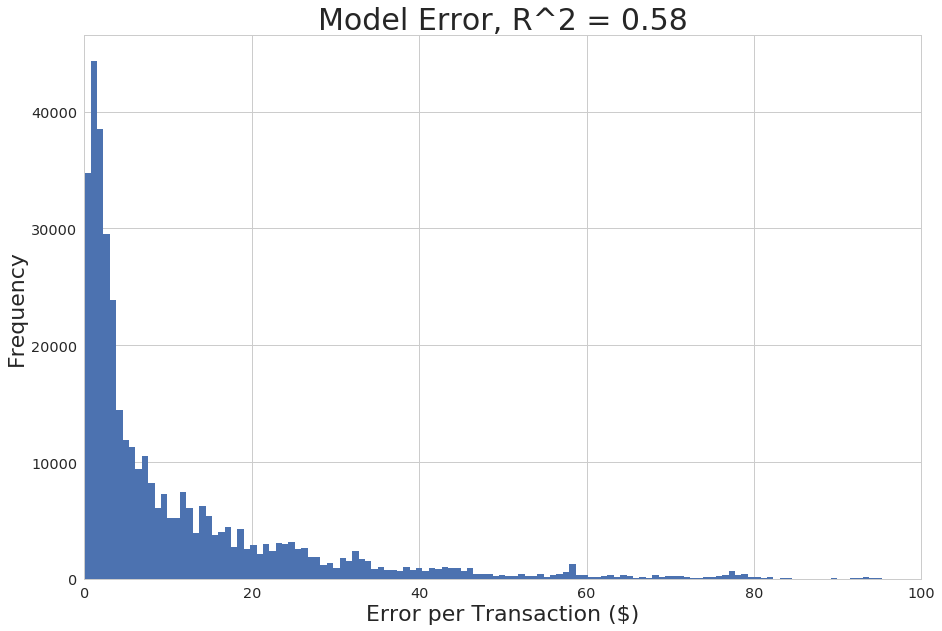

median error, mean error
4.818010360614846 11.014392032595236


In [56]:
# Histogram of linear regression's errors

fig, ax = plt.subplots()
error = abs(y_test - model.predict(X_test))
plt.hist(error, bins=150)
plt.title('Model Error, R^2 = 0.58')
plt.xlabel('Error per Transaction ($)')
plt.xlim(xmin=0)
plt.xlim(xmax=100)
plt.ylabel('Frequency')
plt.show()

print('median error, mean error')
print(np.median(error), np.mean(error))

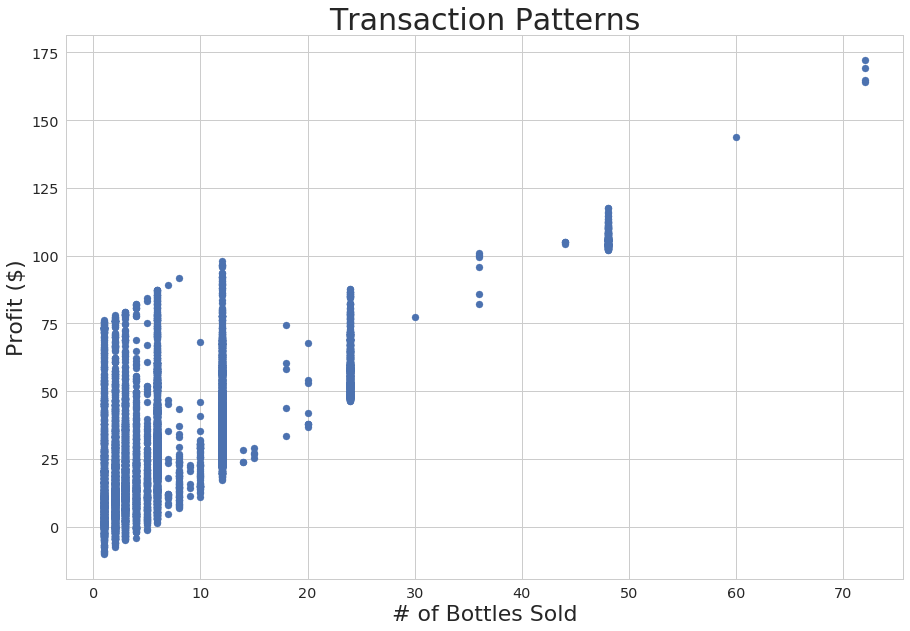

Text(0,0.5,'Profit ($)')

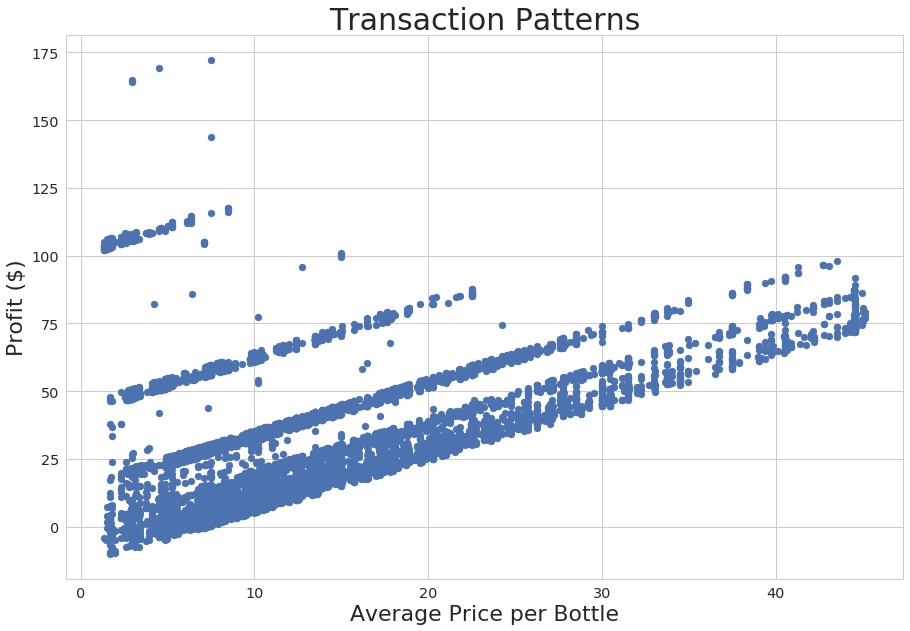

In [59]:
# Visual of feature relationships

fig, ax = plt.subplots()
X_test_sample = X_test.sample(10000)
plt.scatter(X_test_sample.loc[:, 'Bottles Sold'], model.predict(X_test_sample))
plt.title('Transaction Patterns')
plt.xlabel('# of Bottles Sold')
plt.ylabel('Profit ($)')
plt.show()
plt.scatter(X_test_sample.loc[:, 'Price per Bottle'], model.predict(X_test_sample))
plt.title('Transaction Patterns')
plt.xlabel('Average Price per Bottle')
plt.ylabel('Profit ($)')

### Model Interpretation

In [63]:
# Average transaction among top seven counties

model.predict(X_test_sample)
X_test_sample.iloc[3]

Bottles Sold            12.00
Price per Bottle        12.38
County_Johnson           0.00
County_Linn              0.00
County_Polk              1.00
County_Pottawattamie     0.00
County_Scott             0.00
County_Woodbury          0.00
Name: 2261810, dtype: float64

In [65]:
# Profit per transaction using averages and varies location 

print('Black Hawk: ' + str(model.predict([[8.295, 13.897, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])).strip('[]'))
print('Johnson: ' + str(model.predict([[8.295, 13.897, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]])).strip('[]'))
print('Linn: ' + str(model.predict([[8.295, 13.897, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]])).strip('[]'))
print('Polk: ' + str(model.predict([[8.295, 13.897, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]])).strip('[]'))
print('Pottawattamie: ' + str(model.predict([[8.295, 13.897, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]])).strip('[]'))
print('Scott: ' + str(model.predict([[8.295, 13.897, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]])).strip('[]'))
print('Woodbury: ' + str(model.predict([[8.295, 13.897, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])).strip('[]'))


Black Hawk: 30.39579413
Johnson: 33.9423538
Linn: 31.95723346
Polk: 31.86282062
Pottawattamie: 33.25147185
Scott: 31.07056623
Woodbury: 32.96359034


*Transactions that occur in Johnson earn the most profit. If the same transaction occurs in other counties, then expect less profit.*

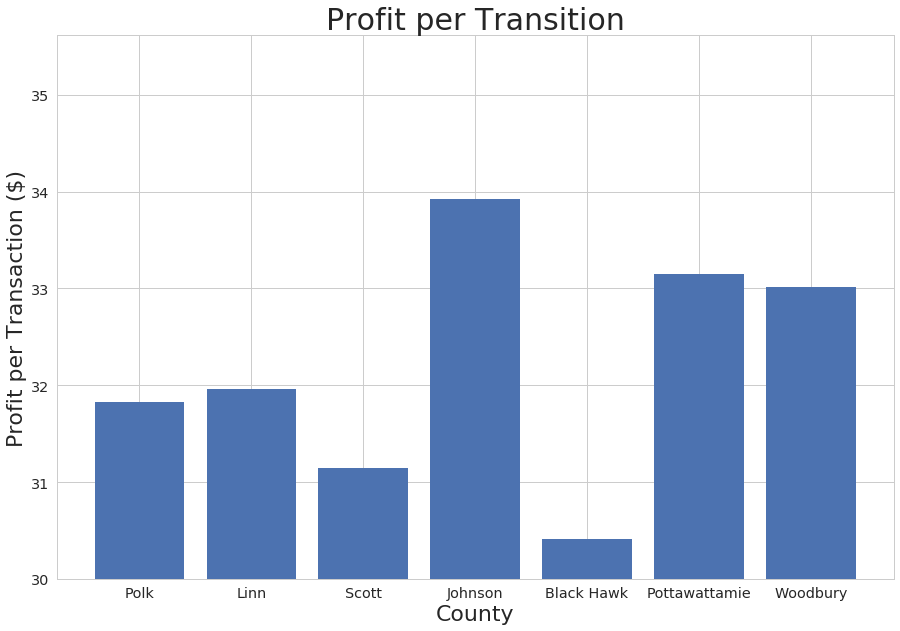

In [76]:
# Let's plot the result

fig, ax = plt.subplots()
plt.bar(range(0,7), [31.83, 31.96, 31.14, 33.92, 30.41, 33.15, 33.01])
plt.xticks(range(0,7), top_county_sales.head(7).index)
plt.title('Profit per Transition')
plt.xlabel('County')
plt.ylim(ymin=30)
plt.ylabel('Profit per Transaction ($)')
plt.show()

In [73]:
# Top store by net profit per transaction

df2 = df[['County', 'Store Name', 'Profit']]
df3_group = df2.groupby(['County', 'Store Name']).agg(sum)
df3_group.sort_values(['Profit'], ascending=False)